W tym zadaniu zajmiemy się klasteryzacją, czyli podziałem danych na zbiory w oparciu o wartości opisujących ich cech.

W przeciwieństwie do klasyfikacji, którą zajmowaliśmy się do tej pory, klasteryzacja nie wymaga posiadania labeli dzielących obiekty na klasy. Jej celem jest eksploracja danych - sprawdzamy, czy dane da się podzielić na skupienia (zbiory różniące się pomiedzy sobą i możliwe do odróżnienia) na podstawie posiadanych cech. Może też służyć do podziału zbioru danych na klasy, utworzenia labeli i potem być wykorzystywana do klasyfikacji.

Na zajęciach będziemy zajmować się jedną metodą klasteryzacji - metodą k-średnich. Polega na tym, że wybieramy liczbę klas, na które chcielibyśmy podzielić dane. Następnie wybierane są środki (tzw. centroidy) tych k klas, np. w sposób losowy, i obliczane odległości obiektów od nich. Obiekty przyporządkowane zostają tej klasie, której centroid znajduje się najbliżej nich. Potem ustalane są nowe środki skupień, np. wyznaczane jako średnia wszystkich obiektów ze skupienia, ponownie wyliczane są odległości obiektów od nowych środków i tworzony jest nowy podział. Te kroki powtarzane są do czasu, aż zostanie osiągnięty warunek zatrzymania (zazwyczaj jest to określona na początku liczba iteracji lub dojście do momentu, gdy podział przestaje się zmieniać pomimo kolejnych iteracji).

Zacznijmy od wczytania danych, na których będziemy pracować. Są to dane dotyczące 8 cech charakteryzujących utwory muzyczne oraz przynależność tych utworów do 16 gatunków muzycznych.

Żródło danych: https://github.com/mdeff/fma

In [6]:
import pandas as pd
import numpy as np

In [7]:
#wczytujemy cechy utworów

feats_col_list = [0,1,2,3,4,5,6,7,8] #bierzemy tylko kolumny z indeksem utworu oraz cechami akustycznymi
feats_df = pd.read_csv("fma_metadata/echonest.csv", usecols=feats_col_list, low_memory=False, header=2) 
#header - numer wiersza, w którym jest nazwa cechy i który będzie nagłówkiem kolumn
#low_memory=False - dzięki temu nie wyświetla się ostrzeżenie, że wcztywane są różne typy danych do jednej tabeli

feats_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True) #zmiana nagłówka pierwszej kolumny
#inplace=True oznacza, że modyfikujemy oryginalną tabelę feats_df, a nie tworzymy jej kopię

feats_df.dropna(inplace=True) #usuwamy wiersze, w których jest NaN (pusta komórka w .CSV)
feats_df.reset_index(drop=True, inplace=True) 
#resetujemy index, żeby był po kolei - po usunięciu wierszy usunięte są też ich indeksy
#drop=True oznacza, że nie tworzymy nowej kolumny z zachowanymi starymi indeksami, bo nie jest nam potrzebna

In [8]:
#wczytujemy przynależność do gatunków

genre_col_list = [0,40]
genre_df = pd.read_csv("fma_metadata/tracks.csv", usecols=genre_col_list, low_memory=False, header=1)
genre_df.rename(columns={'Unnamed: 0': 'track_id'}, inplace=True)
genre_df.dropna(inplace=True)
genre_df.reset_index(drop=True, inplace=True)

Zobaczmy, jakie gatunki muzyczne mamy w wykorzystywanym zbiorze danych:

In [9]:
genre_df["genre_top"].unique()

array(['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz',
       'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues',
       'Country', 'Classical', 'Old-Time / Historic', 'Instrumental',
       'Easy Listening'], dtype=object)

Gatunki są określone słownie, więc takie przypisanie nie nadaje się do zastosowania z większością algorytmów uczenia maszynowego. Musimy przypisać im wartości liczbowe, które mogą służyć jako labele.

In [10]:
#tworzymy słownik, który posłuży do zamiany labeli słownych na numeryczne
labels_dict = {value: index for index, value in enumerate(genre_df["genre_top"].unique())}

#dodajemy nową kolumnę do tabeli genre_df i wpisujemy do niej labele numeryczne poszczególnych utworów
genre_df['genre_numeric_label'] = genre_df["genre_top"].map(labels_dict)

#alternatywny, mniej ładny zapis
# genre_df['genre_numeric_label'] = [labels_dict[genre_df["genre_top"][i]]for i in genre_df.index]

In [11]:
print(labels_dict)

{'Hip-Hop': 0, 'Pop': 1, 'Rock': 2, 'Experimental': 3, 'Folk': 4, 'Jazz': 5, 'Electronic': 6, 'Spoken': 7, 'International': 8, 'Soul-RnB': 9, 'Blues': 10, 'Country': 11, 'Classical': 12, 'Old-Time / Historic': 13, 'Instrumental': 14, 'Easy Listening': 15}


Łączymy obie tabele (z cechami oraz gatunkami i labelami poszczególnych utworów) w taki sposób, żeby zachować tylko indeksy utworów, które występują w obu tabelach (how='inner') i żeby dodawane kolumny były posortowane w ten sam sposób.

In [12]:
all_data_df = pd.merge(feats_df, genre_df, on='track_id', how='inner') #argument on określa, względem której kolumny łączymy tabele

In [13]:
all_data_df

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top,genre_numeric_label
0,2,0.416675,0.675894,0.634476,1.062807e-02,0.177647,0.159310,165.922,0.576661,Hip-Hop,0
1,3,0.374408,0.528643,0.817461,1.851103e-03,0.105880,0.461818,126.957,0.269240,Hip-Hop,0
2,5,0.043567,0.745566,0.701470,6.967990e-04,0.373143,0.124595,100.260,0.621661,Hip-Hop,0
3,10,0.951670,0.658179,0.924525,9.654270e-01,0.115474,0.032985,111.562,0.963590,Pop,1
4,134,0.452217,0.513238,0.560410,1.944269e-02,0.096567,0.525519,114.290,0.894072,Hip-Hop,0
...,...,...,...,...,...,...,...,...,...,...,...
9350,124718,0.412194,0.686825,0.849309,6.000000e-10,0.867543,0.367315,96.104,0.692414,Hip-Hop,0
9351,124719,0.054973,0.617535,0.728567,7.215700e-06,0.131438,0.243130,96.262,0.399720,Hip-Hop,0
9352,124720,0.010478,0.652483,0.657498,7.098000e-07,0.701523,0.229174,94.885,0.432240,Hip-Hop,0
9353,124721,0.067906,0.432421,0.764508,1.625500e-06,0.104412,0.310553,171.329,0.580087,Hip-Hop,0


Każdy utwór opisywany jest przez 8 cech. Jest to zbyt dużo, żeby dało się je łatwo zwizualizować na płaszczyźnie i zobaczyć, czy tworzą się skupienia zawierające utwory z poszczególnych gatunków. Żeby rozwiązać ten problem, zastosujemy PCA i zwizualizujemy dane na płaszczyźnie PC1-PC2.

Nie będziemy robić klasyfikacji, więc możemy do PCA podać wszystkie dane, bez podziału na zbiór uczący i testowy.

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)

#feats_names - wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
feats_names = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"]
PCA_feats = pca.fit_transform(all_data_df[feats_names])

In [15]:
#wyświetlmy, jaka część wariancji jest wyjaśniania przez kolejne składowe główne
pca.explained_variance_ratio_

array([9.99593303e-01, 1.46217409e-04, 1.01635629e-04, 6.54126679e-05,
       4.15434128e-05, 2.13628582e-05, 1.81891615e-05, 1.23354257e-05])

Jak widać, prawie cała wariancja jest wyjaśniana przez zaledwie 1 składową główną. Do tabeli z danymi dodamy PC1 i PC2, żeby dało się naryzować wykres na nowej płaszczyźnie.

In [16]:
all_data_df['PC1'] = PCA_feats[:,0]
all_data_df['PC2'] = PCA_feats[:,1]

Teraz zwizualizujemy dane. Na osi X będzie PC1, na osi Y - PC2. Każdą klasę (gatunek) oznaczymy innym kolorem.

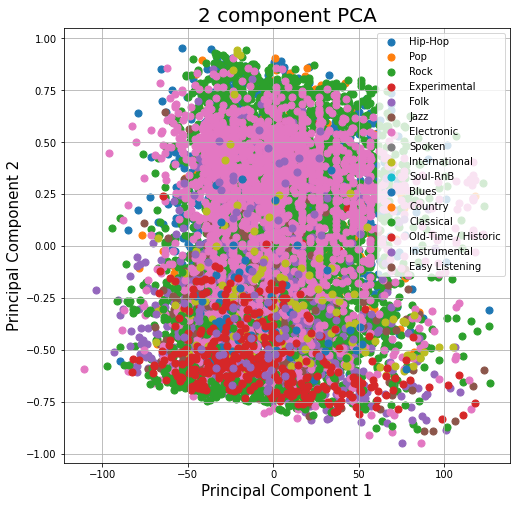

In [17]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,16)
for target in targets:
    indicesToKeep = all_data_df['genre_numeric_label'] == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(genre_df["genre_top"].unique())
ax.grid()

Co prawda składowe PC1 i PC2 wyjaśniają prawie całą wariancję, ale to nie jest wystarczające do tego, by odróżnić od siebie poszczególne gatunki. Na wykresie nakładają się one na siebie i nie są widoczne wyraźne skupienia oddzielone od siebie.

Spróbujemy utworzyć nowe gatunki muzyczne, które byłyby możliwe do odróżnienia od siebie na podstawie składowych głównych. W tym celu wykorzystamy algorytm k-średnich (k-means).

Należy zdefiniować, ile skupień chcemy uzyskać. Na początek dajmy 16, czyli tyle, ile gatunków muzycznych mamy. 

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:2]) 

Powtórzmy wizualizację, tym razem używając labeli przypisanych przez algorytm k-means.

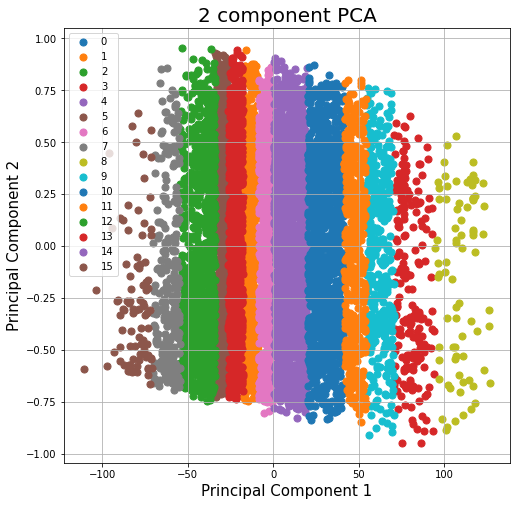

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,16)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(targets)
ax.grid()

Jak widać, powyższe wyniki nie mają większego sensu - skupienia są utworzone, ale stykają się ze sobą i bez zastosowania róznych kolorów nie dałoby się ich zauważyć na wykresie. Ma to związek ze zbyt dużą liczą gatunków oraz cech opisujących sygnały (przed przeprowadzeniem PCA).
Spróbuj uzyskać lepszą klasteryzację:
1. zmniejszając liczbę klas, na które dane mają być podzielone przez algorytm k-średnich
2. zmniejszając liczbę cech, które podawane są do PCA - wybierz takie, które wg Ciebie najlepiej będa nadawały się do odróżniania od siebie gatunków muzycznych (istniejących lub nowych)
3. zmniejszając zarówno liczbę cech, jak i liczbę klas

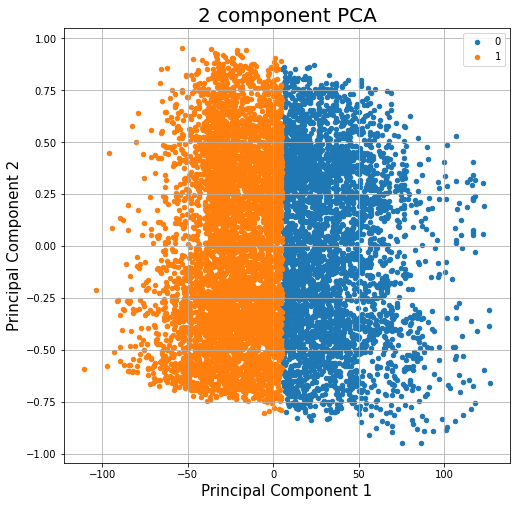

In [39]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,2)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

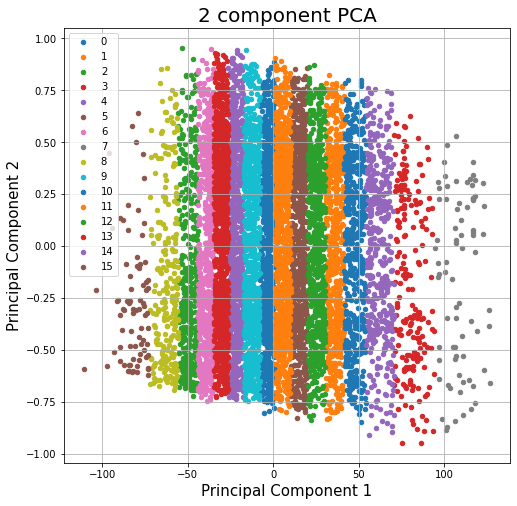

In [40]:
pca = PCA(n_components=2)

#feats_names - wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
feats_names = ["acousticness", "energy", "speechiness", "tempo"]
PCA_feats = pca.fit_transform(all_data_df[feats_names])
kmeans = KMeans(n_clusters=16, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,16)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

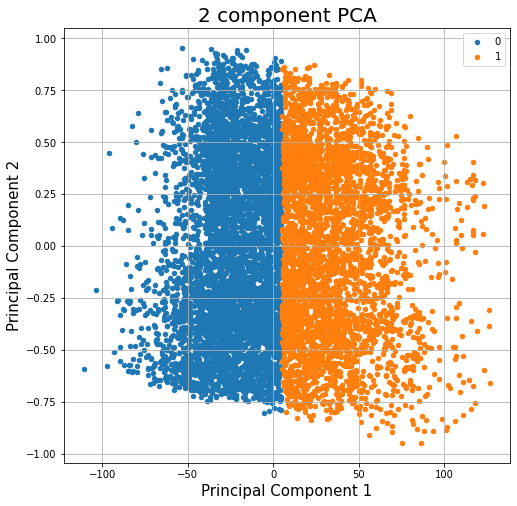

In [41]:

#feats_names - wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
feats_names = ["acousticness", "energy", "speechiness", "tempo"]
pca = PCA(n_components=2)
PCA_feats = pca.fit_transform(all_data_df[feats_names])
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:2]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,2)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

Teraz nowe gatunki tworzyliśmy na podstawie składowych głównych. Można też użyć algorytmu k-średnich na danych oryginalnych i skupienia uzyskane w ten sposób zwizualizować na płaszczyźnie PC1PC2. Zrób to i zobacz, czy podziały uzyskane na podstawie cech oryginalnych oraz składowych głównych będą się mocno różnić.

In [24]:
feats_names = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"]
kmeans = KMeans(n_clusters=16, random_state=0, n_init=10)
kmeans_feats = kmeans.fit_predict(all_data_df[feats_names]) 

Który podział uważasz za lepszy, ten na podstawie cech oryginalnych czy składowych głównych? Który jest wg Ciebie bardziej sensowny pod względem interpretacji tego, na podstawie czego przyporządkowujemy utwory do nowych gatunków?

Jeżeli chcesz sprawdzić, które utwory zostały przyporządkowane do poszczególnych skupień, zobacz kod z zadania 2 - pod koniec jest przykład, jak przeprowadzić taką analizę.

Na wcześniejszych zajęciach mówiliśmy, że dane powinno się ustandaryzować przed wykonaniem PCA. Tutaj tego nie zrobiliśmy, co może mieć istotny wpływ na uzyskane rezultaty. 

Wykonaj standaryzację danych przed użyciem algorytmu PCA i powtórz dalsze kroki aż do wyświetlenia skupień uzyskanych poprzez użycie algorytmu k-średnich. Co sądzisz o wynikach? Czy standaryzacja faktycznie mocno na nie wpływa?

In [25]:
from sklearn.preprocessing import StandardScaler

scaled_feats = StandardScaler().fit_transform(all_data_df[feats_names])

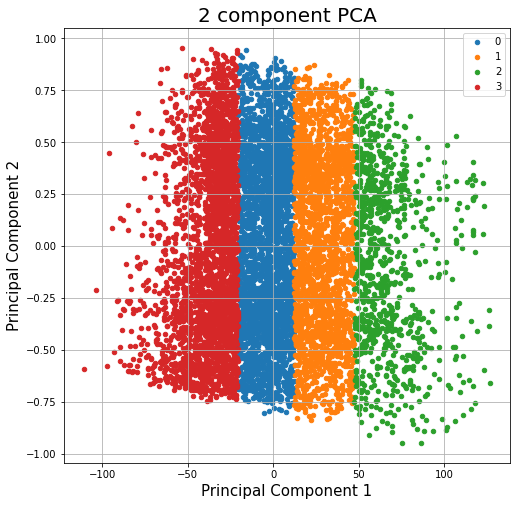

In [26]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:2]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,4)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

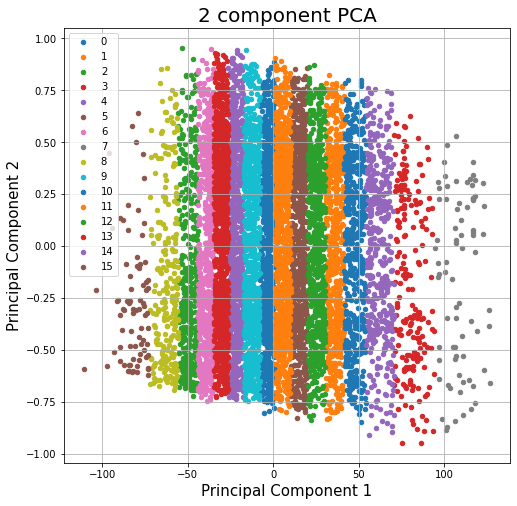

In [27]:
pca = PCA(n_components=4)

#feats_names - wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
feats_names = ["acousticness", "energy", "speechiness", "tempo"]
PCA_feats = pca.fit_transform(all_data_df[feats_names])
kmeans = KMeans(n_clusters=16, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:2]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,16)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

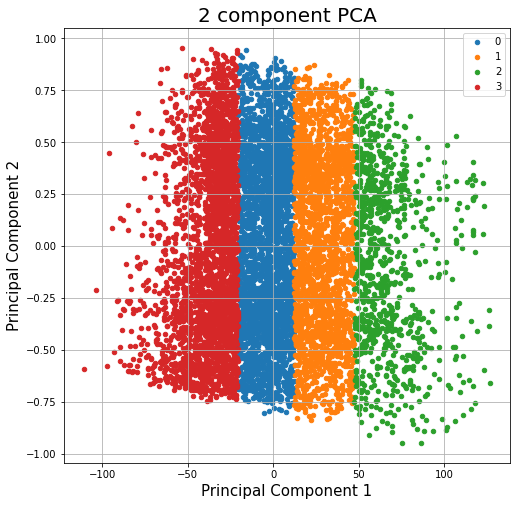

In [28]:

#feats_names - wektor zawierający nazwy cech, które będą podane do PCA. Na razie bierzemy wszystkie 8
feats_names = ["acousticness", "energy", "speechiness", "tempo"]
PCA_feats = pca.fit_transform(all_data_df[feats_names])
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10) #n_init - liczba losowych podziałów na skupienia, które zostaną wykonane. Ostateczny podział jest wybierany spośród n wykonanych podziałów tak, by odległości centroidów od wszystkich obiektów w skupieniu były możliwie najmniejsze
#znajdujemy skupienia w danych oraz przypisujemy obserwacjom nowe labele (nowe gatunki)
kmeans_labels = kmeans.fit_predict(PCA_feats[:,:2]) 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = range(0,4)
for target in targets:
    indicesToKeep = kmeans_labels == target
    ax.scatter(all_data_df.loc[indicesToKeep, 'PC1']
               , all_data_df.loc[indicesToKeep, 'PC2']
               , s = 20)
ax.legend(targets)
ax.grid()

[ 9  5 12 ...  0  9  4]


<function matplotlib.pyplot.show(close=None, block=None)>

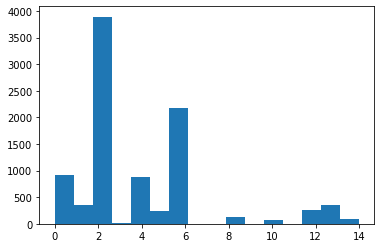

In [56]:
feats_names = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "speechiness", "tempo", "valence"]
kmeans = KMeans(n_clusters=16, random_state=0, n_init=10)
kmeans_feats = kmeans.fit_predict(all_data_df[feats_names])
print(kmeans_feats)
true_genre = all_data_df['genre_numeric_label']
plt.hist(true_genre,16)
plt.show